#  Se importan las librerías necesarias y accede al CSV con los datos de precios de cierre.

In [78]:
import pandas as pd
import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypfopt import CLA, EfficientFrontier, expected_returns, risk_models, plotting
import seaborn as sns




archivo_csv = 'Precios_Marzo.csv' 

archivo_csv = 'Precios_Marzo.csv'
adj_close_df = pd.read_csv(
    archivo_csv, 
    sep=';', 
    index_col=0, 
    decimal=',', 
    thousands='.'
)
adj_close_df.index = pd.to_datetime(adj_close_df.index, dayfirst=True)

adj_close_df = adj_close_df.dropna()

print(adj_close_df.tail()) # Se imprime las últimas filas (más cercanas temporalmente).

    


            EEWD.L       ESGV  SDUE.L  SWDA.L      CSUS.L   IMEU.L    XBAE.DE  \
Date                                                                            
2024-06-27  8.3405  97.019997  6.1150  8025.0  553.960022  2722.75  20.059999   
2024-06-28  8.3790  96.620003  6.1050  8072.0  557.229981  2722.00  20.042000   
2024-07-01  8.3370  96.860001  6.1370  8031.0  553.349976  2733.00  19.932501   
2024-07-02  8.3560  97.500000  6.0955  8027.0  555.280029  2717.00  19.966999   
2024-07-03  8.4355  97.970001  6.1325  8046.0  559.349976  2733.50  20.040001   

                 EAGG     SEAG.L  AGGG.L        AGG  BGIEAA2  
Date                                                          
2024-06-27  46.643288  90.824997  4.2725  97.247513   104.88  
2024-06-28  46.444000  90.885002  4.2675  96.768997   105.43  
2024-07-01  46.180000  90.605003  4.2430  96.250000   105.43  
2024-07-02  46.340000  90.525002  4.2530  96.570000   105.07  
2024-07-03  46.630001  90.779999  4.2730  97.089996   

# Primer análisis: conjunto de activos sostenibles vs tradicionales

# 1. Normalización precios

In [29]:
# Normalización de los precios de cierre ajustados
normalized_df = adj_close_df / adj_close_df.iloc[0] * 100


# 2. Calcular el rendimiento promedio de los dos conjuntos: Activos sostenibles y activos tradicionales

In [30]:
# Cálculo del promedio de cada conjunto de activos
mean_performance_set1 = normalized_df[['SDUE.L', 'ESGV', 'EEWD.L', 'SEAG.L', 'XBAE.DE', "EAGG"]].mean(axis=1)
mean_performance_set2 = normalized_df[['IMEU.L', 'CSUS.L', 'SWDA.L', 'BGIEAA2', 'AGG', 'AGGG.L']].mean(axis=1)


# 3. Creo un DataFrame (una tabla) para poder graficar los índices

In [31]:
# Crear un nuevo DataFrame para el gráfico
mean_df = pd.DataFrame({
    'Activos sostenibles': mean_performance_set1,
    'Activos tradicionales': mean_performance_set2
})


# 4. Obtengo los resultados de los índices para el último día

In [35]:
# Obtener los valores finales
final_value_sostenibles = mean_df['Activos sostenibles'].iloc[-1]
final_value_tradicionales = mean_df['Activos tradicionales'].iloc[-1]

print(final_value_sostenibles, final_value_tradicionales)

137.05313070663442 138.12071563786878


# 5. Configuro y creo el gráfico

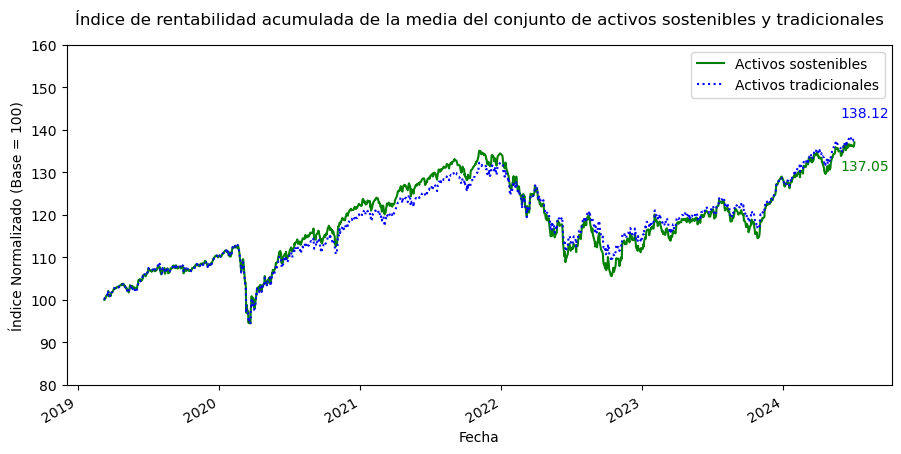

In [39]:
# Crear gráfico y ajustar márgenes
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplots_adjust(right=0.95)  # Aumentar el margen derecho para más espacio

# Graficar los datos
mean_df.plot(ax=ax, color=['green', 'blue'], style=['-', ':'])
plt.title('Índice de rentabilidad acumulada de la media del conjunto de activos sostenibles y tradicionales', pad=15)
plt.xlabel('Fecha')
plt.ylabel('Índice Normalizado (Base = 100)')
plt.ylim(80, 160)

# Anotar los valores finales en el gráfico
ax.annotate(f'{final_value_sostenibles:.2f}', 
            xy=(mean_df.index[-1], final_value_sostenibles), 
            xytext=(-10, -20),  # Ajustar desplazamiento en X
            textcoords='offset points', 
            color='green', fontsize=10);

# Ajustar la posición del valor de los activos tradicionales
ax.annotate(f'{final_value_tradicionales:.2f}', 
            xy=(mean_df.index[-1], final_value_tradicionales), 
            xytext=(-10, 15),  # Ajustar desplazamiento en Y y X
            textcoords='offset points', 
            color='blue', fontsize=10);

# Mostrar la leyenda y el gráfico
plt.legend()
plt.show()


# 6. Correlación del conjunto de activos sostenibles y tradicionales

In [41]:
# Calcular la correlación entre los índices de activos sostenibles y tradicionales
correlation = mean_df['Activos sostenibles'].corr(mean_df['Activos tradicionales'])
print("Correlación entre activos sostenibles y tradicionales:", correlation)


Correlación entre activos sostenibles y tradicionales: 0.9840593530857419


# 7.Rentabilidad acumulada del conjunto de activos sostenibles y tradicionales

In [6]:
# Calcular la rentabilidad acumulada de los activos sostenibles
initial_value_sostenibles = mean_df['Activos sostenibles'].iloc[0]
final_value_sostenibles = mean_df['Activos sostenibles'].iloc[-1]
rentabilidad_acumulada_sostenibles = (final_value_sostenibles - initial_value_sostenibles) / initial_value_sostenibles * 100
print("Rentabilidad acumulada de activos sostenibles:", rentabilidad_acumulada_sostenibles, "%")

# Calcular la rentabilidad acumulada de los activos tradicionales
initial_value_tradicionales = mean_df['Activos tradicionales'].iloc[0]
final_value_tradicionales = mean_df['Activos tradicionales'].iloc[-1]
rentabilidad_acumulada_tradicionales = (final_value_tradicionales - initial_value_tradicionales) / initial_value_tradicionales * 100
print("Rentabilidad acumulada de activos tradicionales:", rentabilidad_acumulada_tradicionales, "%")


Rentabilidad acumulada de activos sostenibles: 37.05313070663442 %
Rentabilidad acumulada de activos tradicionales: 38.120715637868784 %


# 8. Desviación estándar conjunto activos sostenibles y tradicionales

In [7]:
# Calcular la desviación estándar (volatilidad) de los activos sostenibles
desviacion_sostenibles = mean_df['Activos sostenibles'].std()
print("Desviación estándar de activos sostenibles:", desviacion_sostenibles)

# Calcular la desviación estándar (volatilidad) de los activos tradicionales
desviacion_tradicionales = mean_df['Activos tradicionales'].std()
print("Desviación estándar de activos tradicionales:", desviacion_tradicionales)


Desviación estándar de activos sostenibles: 9.57101064629884
Desviación estándar de activos tradicionales: 9.192828710041029


# Segundo análisis: retorno, volatilidad y Sharpe para todos los activos

## 1. Hallo retornos y matriz de covarianza de todos los activos

In [57]:
mu = expected_returns.mean_historical_return(adj_close_df) #Hallo el retorno compuesto anualizado esperado
S = risk_models.sample_cov(adj_close_df)


## 2. Hallo y grafico los retornos, diferenciando por colores.  

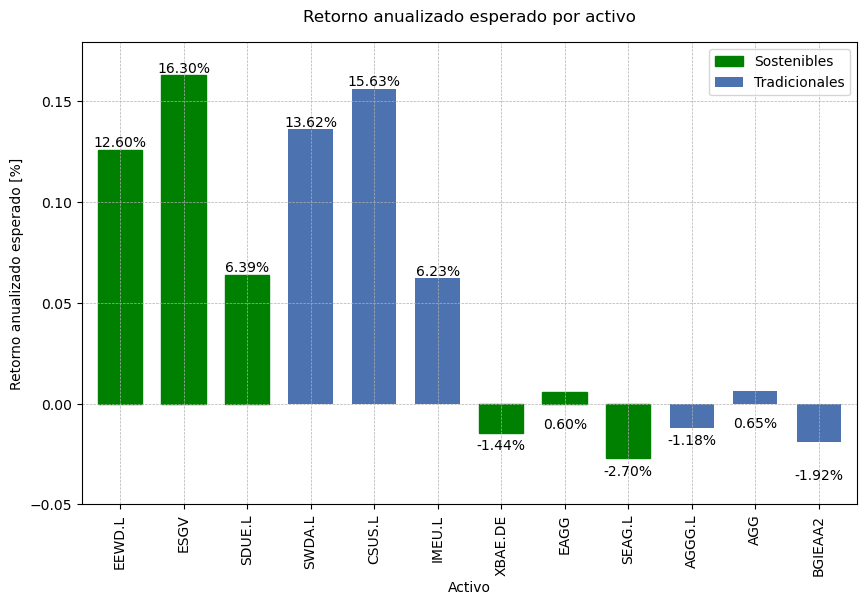

In [53]:
# Definir los activos sostenibles
green_tickers = ['SDUE.L', 'ESGV', 'EEWD.L', 'SEAG.L', 'EAGG', 'XBAE.DE']

# Crear el gráfico de barras
ax = mu.plot.bar(figsize=(10, 6), alpha=1, width=0.7)

# Definir activos que necesitan ajustes en las etiquetas
higher_label_assets = ['XBAE.DE', 'EAGG', 'SEAG.L', 'AGGG.L', 'AGG']
more_negative_offset_assets = ['EAGG', 'AGG', 'BGIEAA2']


# Iterar sobre cada barra para cambiar el color y ajustar las etiquetas
for i, bar in enumerate(ax.patches):  # ax.patches contiene todas las barras
    # Cambiar el color a verde si el activo está en la lista green_tickers
    if mu.index[i] in green_tickers:
        bar.set_color('green')
    
    # Determinar el offset de la etiqueta basado en el grupo de activos
    if mu.index[i] in more_negative_offset_assets:
        label_offset = -0.02
    elif mu.index[i] in higher_label_assets:
        label_offset = -0.01
    else:
        label_offset = 0

    # Añadir la etiqueta de texto
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + label_offset, f'{mu.iloc[i]*100:.2f}%', ha='center', va='bottom')

plt.xlabel('Activo')  # Etiqueta para el eje horizontal
plt.ylabel('Retorno anualizado esperado [%]')  # Etiqueta para el eje vertical
plt.title('Retorno anualizado esperado por activo', pad=15)  # Título del gráfico

sustainable_handle = plt.Rectangle((0,0),1,1, color='green', label='Sostenibles')
traditional_handle = plt.Rectangle((0,0),1,1,  label='Tradicionales')  
plt.legend(handles=[sustainable_handle, traditional_handle])

# Ajustar el límite inferior del eje Y
ax.set_ylim([-0.05, max(mu)*1.1])  # Extender hasta -0.05 y un poco más allá del valor máximo para espacio

# Añadir cuadrícula para mejor visualización
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()


## 3. Hallo y grafico la volatilidad por activo, diferenciando por colores

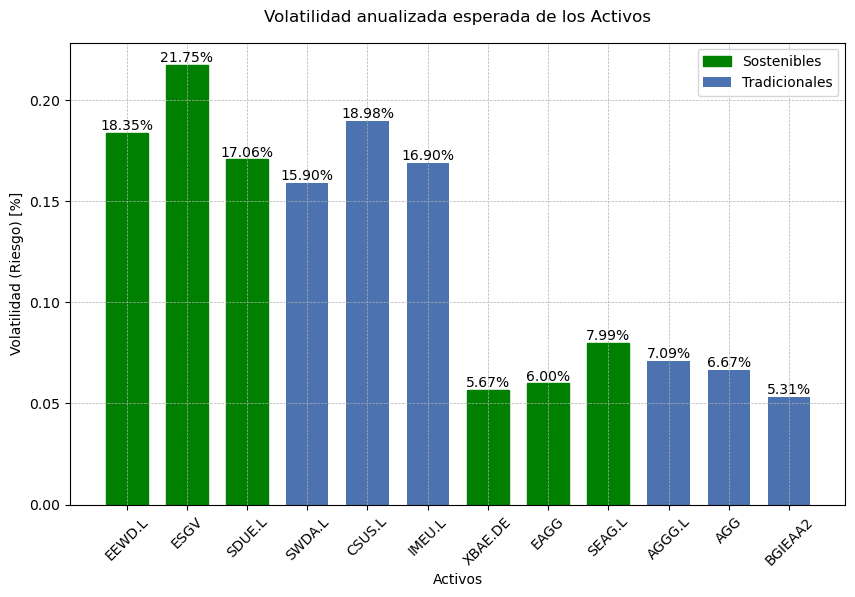

In [58]:
# Suponiendo que asset_risks y mu están definidos correctamente
# mu puede ser un DataFrame o Serie que contiene los nombres de los activos como índice
import matplotlib.patches as mpatches

asset_risks = np.sqrt(np.diag(S))

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(mu.index, asset_risks, alpha=1,  width=0.7)  # Especifica alpha=1 para opacidad completa

# Definir los activos que deben estar en verde
green_assets = ['SDUE.L', 'ESGV', 'EEWD.L', 'SEAG.L', 'EAGG', 'XBAE.DE']

# Cambiar el color de las barras específicas a verde
for bar, label in zip(bars, mu.index):
    if label in green_assets:
        bar.set_color('green')  # Setea el color de la barra a verde

     
plt.title("Volatilidad anualizada esperada de los Activos", pad = 15)
plt.xlabel("Activos")
plt.ylabel("Volatilidad (Riesgo) [%]")
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor visualización
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Añadir etiquetas de texto en cada barra en formato porcentual
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}%', ha='center', va='bottom')  # Formatear como porcentaje
green_patch = mpatches.Patch(color='green', label='Sostenibles')
blue_patch = mpatches.Patch(label='Tradicionales')
plt.legend(handles=[green_patch, blue_patch])
plt.show()

# Tercer análisis:  rentabilidades y volatilidades y sharpe por grupo. También sharpe por activo

## 1. Sharpe de todos los activos

### 1.1  Hallo la tasa libre de riesgo  desde la web de la FED a fecha de 7 de julio 

In [73]:
from fredapi import Fred
from datetime import datetime

# Inicializa la API de Fred con tu clave de API
fred = Fred(api_key="4d34eda45a97e45269f523f18ce6ec5d")

# Establece la fecha específica que te interesa
fecha_interes = datetime(2024, 7, 7)

# Obtiene la serie de datos para GS10 alrededor de la fecha de interés
ten_year_treasury_rate = fred.get_series("GS10", observation_start=fecha_interes, observation_end=fecha_interes)

# Divide por 100 para convertir la tasa de porcentaje a formato decimal
ten_year_treasury_rate /= 100

# Obtén la tasa libre de riesgo si los datos están disponibles para esa fecha
risk_free_rate = ten_year_treasury_rate.iloc[0] if not ten_year_treasury_rate.empty else None

# Imprime la tasa libre de riesgo
if risk_free_rate is not None:
    print("Tasa libre de riesgo para el 7 de julio de 2024:", risk_free_rate)
else:
    print("No hay datos disponibles para la fecha especificada.")

Tasa libre de riesgo para el 7 de julio de 2024: 0.0425


### 1.2 Hallo Sharpe de todos los activos 

In [74]:
sharpe_activos=(mu - risk_free_rate) / asset_risks

sharpe_activos

EEWD.L     0.455059
ESGV       0.554042
SDUE.L     0.125571
SWDA.L     0.589090
CSUS.L     0.599519
IMEU.L     0.117185
XBAE.DE   -1.003702
EAGG      -0.609089
SEAG.L    -0.869841
AGGG.L    -0.765537
AGG       -0.540124
BGIEAA2   -1.163321
dtype: float64

## 2.1 Retorno  por grupos 

In [75]:
# Grupo 1: EEWD.L, ESGV, SDUE.L
mean_return_group1 = mu[['EEWD.L', 'ESGV', 'SDUE.L']].mean()

# Grupo 2: SWDA.L, CSUS.L, IMEU.L
mean_return_group2 = mu[['SWDA.L', 'CSUS.L', 'IMEU.L']].mean()

# Grupo 3: XBAE.DE, EAGG, SEAG.L
mean_return_group3 = mu[['XBAE.DE', 'EAGG', 'SEAG.L']].mean()

# Grupo 4: AGGG.L, AGG, BGIEAA2
mean_return_group4 = mu[['AGGG.L', 'AGG', 'BGIEAA2']].mean()

# Imprimir los resultados
print(f"Retorno medio del Grupo 1: {mean_return_group1*100:.2f}%")
print(f"Retorno medio del Grupo 2: {mean_return_group2*100:.2f}%")
print(f"Retorno medio del Grupo 3: {mean_return_group3*100:.2f}%")
print(f"Retorno medio del Grupo 4: {mean_return_group4*100:.2f}%")



Retorno medio del Grupo 1: 11.76%
Retorno medio del Grupo 2: 11.83%
Retorno medio del Grupo 3: -1.18%
Retorno medio del Grupo 4: -0.82%


## 2.2 Grafico la correlación entre grupos

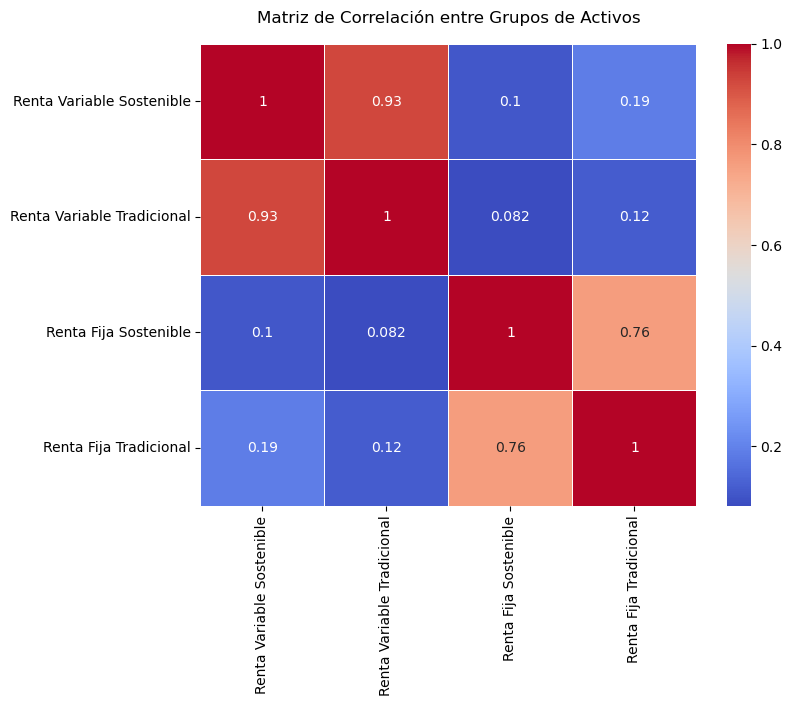

Retorno medio del Grupo 1 (Renta Variable Sostenible): 11.76%
Retorno medio del Grupo 2 (Renta Variable Tradicional): 11.83%
Retorno medio del Grupo 3 (Renta Fija Sostenible): -1.18%
Retorno medio del Grupo 4 (Renta Fija Tradicional): -0.82%


In [76]:
group_returns = pd.DataFrame({
    'Renta Variable Sostenible': [mean_return_group1],
    'Renta Variable Tradicional': [mean_return_group2],
    'Renta Fija Sostenible': [mean_return_group3],
    'Renta Fija Tradicional': [mean_return_group4]
})

# Como solo tienes un valor por grupo, no es posible calcular una correlación con estos valores escalares
# Necesitamos trabajar con los retornos históricos para calcular correlaciones reales entre los grupos

# Usar los precios de cierre ajustados para calcular retornos históricos diarios para cada grupo
returns_df = expected_returns.returns_from_prices(adj_close_df)

# Agrupar los retornos históricos por grupos
grouped_returns = pd.DataFrame({
    'Renta Variable Sostenible': returns_df[['EEWD.L', 'ESGV', 'SDUE.L']].mean(axis=1),
    'Renta Variable Tradicional': returns_df[['SWDA.L', 'CSUS.L', 'IMEU.L']].mean(axis=1),
    'Renta Fija Sostenible': returns_df[['XBAE.DE', 'EAGG', 'SEAG.L']].mean(axis=1),
    'Renta Fija Tradicional': returns_df[['AGGG.L', 'AGG', 'BGIEAA2']].mean(axis=1)
})

# Calcular la matriz de correlación entre los retornos diarios promedio de los grupos
correlation_matrix = grouped_returns.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación entre Grupos de Activos', pad=15)
plt.show()

# Imprimir los resultados de los retornos medios esperados
print(f"Retorno medio del Grupo 1 (Renta Variable Sostenible): {mean_return_group1*100:.2f}%")
print(f"Retorno medio del Grupo 2 (Renta Variable Tradicional): {mean_return_group2*100:.2f}%")
print(f"Retorno medio del Grupo 3 (Renta Fija Sostenible): {mean_return_group3*100:.2f}%")
print(f"Retorno medio del Grupo 4 (Renta Fija Tradicional): {mean_return_group4*100:.2f}%")

## 3. Volatilidad por grupos 

In [63]:
# Pesos iguales (1/3) para cada activo en cada grupo
weights = np.array([1/3, 1/3, 1/3])

# Grupo 1: Renta Variable Sostenible (EEWD.L, ESGV, SDUE.L)
cov_matrix_group1 = S.loc[['EEWD.L', 'ESGV', 'SDUE.L'], ['EEWD.L', 'ESGV', 'SDUE.L']]
volatility_group1 = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_group1, weights)))

# Grupo 2: Renta Variable Tradicional (SWDA.L, CSUS.L, IMEU.L)
cov_matrix_group2 = S.loc[['SWDA.L', 'CSUS.L', 'IMEU.L'], ['SWDA.L', 'CSUS.L', 'IMEU.L']]
volatility_group2 = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_group2, weights)))

# Grupo 3: Renta Fija Sostenible (XBAE.DE, EAGG, SEAG.L)
cov_matrix_group3 = S.loc[['XBAE.DE', 'EAGG', 'SEAG.L'], ['XBAE.DE', 'EAGG', 'SEAG.L']]
volatility_group3 = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_group3, weights)))

# Grupo 4: Renta Fija Tradicional (AGGG.L, AGG, BGIEAA2)
cov_matrix_group4 = S.loc[['AGGG.L', 'AGG', 'BGIEAA2'], ['AGGG.L', 'AGG', 'BGIEAA2']]
volatility_group4 = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_group4, weights)))

# Imprimir los resultados
print(f"Volatilidad total de Renta Variable Sostenible: {volatility_group1:.4f}")
print(f"Volatilidad total de Renta Variable Tradicional: {volatility_group2:.4f}")
print(f"Volatilidad total de Renta Fija Sostenible: {volatility_group3:.4f}")
print(f"Volatilidad total de Renta Fija Tradicional: {volatility_group4:.4f}")




Volatilidad total de Renta Variable Sostenible: 0.1678
Volatilidad total de Renta Variable Tradicional: 0.1625
Volatilidad total de Renta Fija Sostenible: 0.0524
Volatilidad total de Renta Fija Tradicional: 0.0448


## 4. Sharpe por grupos 

In [68]:
# Suponiendo que tienes los retornos medios y las volatilidades calculadas como en los ejemplos anteriores

# Ratio de Sharpe = (Retorno medio del activo - Tasa libre de riesgo) / Volatilidad del activo

# Calcular los ratios de Sharpe para cada grupo
sharpe_ratio_group1 = (mean_return_group1 - risk_free_rate) / volatility_group1
sharpe_ratio_group2 = (mean_return_group2 - risk_free_rate) / volatility_group2
sharpe_ratio_group3 = (mean_return_group3 - risk_free_rate) / volatility_group3
sharpe_ratio_group4 = (mean_return_group4 - risk_free_rate) / volatility_group4

# Imprimir los ratios de Sharpe
print(f"Ratio de Sharpe del Grupo 1: {sharpe_ratio_group1:.4f}")
print(f"Ratio de Sharpe del Grupo 2: {sharpe_ratio_group2:.4f}")
print(f"Ratio de Sharpe del Grupo 3: {sharpe_ratio_group3:.4f}")
print(f"Ratio de Sharpe del Grupo 4: {sharpe_ratio_group4:.4f}")


Ratio de Sharpe del Grupo 1: 0.4478
Ratio de Sharpe del Grupo 2: 0.4661
Ratio de Sharpe del Grupo 3: -1.0361
Ratio de Sharpe del Grupo 4: -1.1309


# Cuarto análisis: Hallar la cartera eficiente

## 1. Utilizo el optimizador de PyportfoliOpt


In [69]:
## Configurar el optimizador
ef = EfficientFrontier(mu, S)

weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
print(weights)

# Evaluar el rendimiento del portafolio usando la misma tasa libre de riesgo
performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
print(performance)

OrderedDict([('EEWD.L', 0.0), ('ESGV', 0.3229568906498637), ('SDUE.L', 0.0), ('SWDA.L', 0.393572644324407), ('CSUS.L', 0.2834704650257292), ('IMEU.L', 0.0), ('XBAE.DE', 0.0), ('EAGG', 0.0), ('SEAG.L', 0.0), ('AGGG.L', 0.0), ('AGG', 0.0), ('BGIEAA2', 0.0)])
Expected annual return: 15.1%
Annual volatility: 16.6%
Sharpe Ratio: 0.65
(0.15053333579921294, 0.16595978550215193, 0.650960926903657)


## 2. Hallo la matriz de correlación de los activos que la componen para explicar la diversificación 

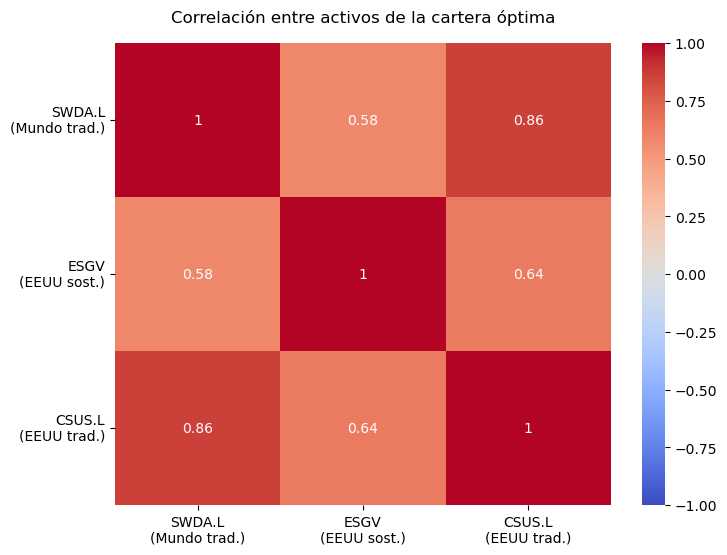

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una copia de los datos para no modificar el original
selected_assets = adj_close_df[['SWDA.L', 'ESGV', 'CSUS.L']].copy()

# Renombrar las columnas para incluir las descripciones en nuevas líneas
selected_assets.rename(columns={
    'SWDA.L': 'SWDA.L\n(Mundo trad.)',
    'ESGV': 'ESGV\n(EEUU sost.)',
    'CSUS.L': 'CSUS.L\n(EEUU trad.)'
}, inplace=True)

# Calcular los rendimientos diarios
returns = selected_assets.pct_change().dropna()

# Calcular la matriz de correlación
correlation_matrix = returns.corr()

# Crear el gráfico de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=True, yticklabels=True)

# Ajustar las etiquetas del eje Y para que estén en horizontal
plt.yticks(rotation=0)

# Añadir título
plt.title('Matriz de Correlación')

plt.title('Correlación entre activos de la cartera óptima', pad=15)


# Mostrar el gráfico
plt.show()
